In [1]:
## Packages and functions. Special thanks to Morgan Frank for ThreadedMap, loadBagrowColors, and the functions below!
## Accompanying ThreadedMap, loadBagrowColors, and myStats python files must be placed in the python path.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection
import pandas as pd
from loadBagrowColors import colors as myColors
import igraph as ig
from ThreadedMap import staticMap
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, leaves_list
from scipy.spatial.distance import pdist

Something weird (Monorepo requires Python 3.11 or later) has happened while importing numpy.exceptions. This is possible if you have a broken Python installation. Consider setting OAIPKG_DISABLE_META_MISSING=1.
Something weird (Monorepo requires Python 3.11 or later) has happened while importing loadBagrowColors. This is possible if you have a broken Python installation. Consider setting OAIPKG_DISABLE_META_MISSING=1.


ModuleNotFoundError: No module named 'loadBagrowColors'

In [3]:
# set the seed
np.random.seed(42)


def echo(X):
    return np.array(X)[0]


def simpleHist(X, numBins=20):
    counts, bins = np.histogram(X, bins=numBins)
    plt.plot(bins[:-1], counts, "k-o")


def clusterMat(M, how="average", **kwargs):
    Z = linkage(M, how)
    order = leaves_list(Z)
    m = M[order, :]
    m = m[:, order]
    plt.imshow(m, aspect="auto", interpolation="nearest", **kwargs)
    plt.colorbar()


def RCA(X, binarized=False):
    rca = (X / np.sum(X, axis=1, keepdims=True)) / (
        np.sum(X, axis=0, keepdims=True) / np.sum(X)
    )
    if not binarized:
        return rca
    rca2 = np.zeros(rca.shape)
    rca2[(rca > 1)] = 1.0
    return rca2


def relateFeatures(mat, verbose=True):
    # row-wise comparison
    # defaults to Sorenson Similarity
    numRows = mat.shape[0]
    out = np.zeros((numRows, numRows))
    S = np.sum(mat, axis=1)
    progress = 0.1
    for i in range(numRows):
        out[i, :] = 2 * np.dot(mat, mat[i, :]) / (S + S[i])
        if verbose and i / numRows >= progress:
            print("%0.2f" % progress)
            while progress <= i / numRows:
                progress += 0.1
    return out


def get_rca(temp):
    # should be:
    #  rows: jobs (or cities)
    #  columns: skills
    return (temp / np.sum(temp, axis=1, keepdims=True)) / (
        np.sum(temp, axis=0, keepdims=True) / temp.sum()
    )


def findIndex(x, X):
    for i in range(len(X)):
        if X[i] == x:
            return i
    return i

In [4]:
tab20_colorNames = [
    "dark blue",
    "light blue",
    "orange",
    "light orange",
    "dark green",
    "light green",
    "red",
    "light red",
    "purple",
    "light purple",
    "brown",
    "light brown",
    "pink",
    "light pink",
    "grey",
    "light grey",
    "pale green",
    "light pale green",
    "cyan",
    "light cyan",
]

In [5]:
## file read-ins

## set your working directory here and drop the data folder in it!
curdir = "/Your/Folder/Goes/Here/"

## data read-in
jobTasksIn = pd.read_csv(f"{curdir}data/task_ratings_file_7-12.csv")
taskDWAS = pd.read_csv(f"{curdir}data/DWA_Tasks_Labels.tsv", sep="\t")

In [6]:
taskDWAS = taskDWAS[
    ["O*NET-SOC Code", "Task ID", "DWA ID", "DWA Title"]
].drop_duplicates()
jobTasksDWAs = pd.merge(
    jobTasksIn, taskDWAS, how="inner", on=["Task ID", "O*NET-SOC Code"]
)
jobDWAs = (
    jobTasksDWAs[
        [item for item in list(jobTasksDWAs) if item not in ["Task", "Task ID"]]
    ]
    .groupby(["O*NET-SOC Code", "DWA Title", "DWA ID", "Title"])
    .mean()
    .reset_index()
)
jobTasks = jobDWAs[
    [
        "O*NET-SOC Code",
        "Title",
        "DWA ID",
        "DWA Title",
        "mean_rating_human_alpha",
        "gpt4_rubric1_alpha",
    ]
].copy()
temp = jobTasks.copy()


def getTemp():
    temp = jobTasks.copy()
    return temp

#Jobs: 923, #DWA: 2084
0.10
0.20
0.30
0.40
0.50
0.60
0.70
0.80
0.90


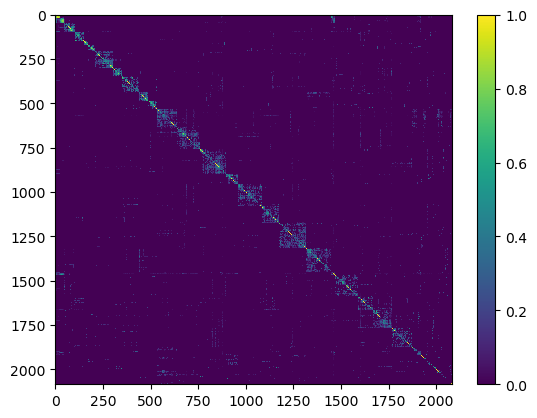

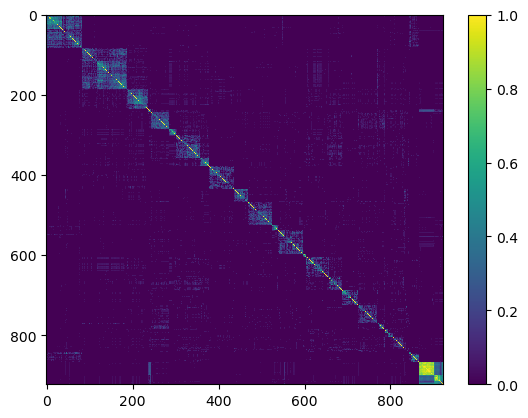

In [7]:
## setting parameters for the network plot. this is important!!
jobTitles = temp["Title"].unique()
DWAs = temp["DWA Title"].unique()
rating_desired = (
    "mean_rating_human_alpha"  # this is where we set the rating we're trying to plot!
)


def getJobTitle(code):
    x = jobTasks[jobTasks["O*NET-SOC Code"] == code]
    if x["Title"].count() > 0:
        return x.iloc[0]["Title"]
    return "Missing job code!"


numJobs = len(jobTitles)
numDWA = len(DWAs)
print("#Jobs: %d, #DWA: %d" % (numJobs, numDWA))
jobDwaMat = np.zeros((numJobs, numDWA))
SML = np.zeros(numDWA)


def findIndex(x, X):
    for i in range(len(X)):
        if X[i] == x:
            return i
    return i


count = -1
progress = 0.1
total = float(temp["Title"].count())
for _, row in temp.iterrows():
    count += 1
    job, dwa = row["Title"], row["DWA Title"]
    jobIndex = findIndex(job, jobTitles)
    dwaIndex = findIndex(dwa, DWAs)
    jobDwaMat[jobIndex, dwaIndex] = 1
    SML[dwaIndex] = row[rating_desired]
    if count / total >= progress:
        print("%0.2f" % progress)
        while progress <= count / total:
            progress += 0.1

jobDwaRca = RCA(jobDwaMat)
jobDwaRca2 = RCA(jobDwaMat, True)

dwaDwa = np.nan_to_num(relateFeatures(jobDwaRca2.T, verbose=False))
jobJob = np.nan_to_num(relateFeatures(jobDwaRca2, verbose=False))

plt.figure()
clusterMat(dwaDwa)
plt.figure()
clusterMat(jobJob)

In [8]:
## network build code


def buildGraph(mat, nodeLabels):
    G = ig.Graph(directed=False)
    for i in range(mat.shape[0]):
        G.add_vertex(i, title=nodeLabels[i])
    edgeData = []
    for i in range(mat.shape[0]):
        for j in range(i + 1, mat.shape[0]):
            if mat[i, j] > 0:
                edgeData.append([i, j, mat[i, j]])
    G.add_edges([(e[0], e[1]) for e in edgeData])
    G.es["weight"] = [e[2] for e in edgeData]
    G.vs["louvain community"] = np.array(
        G.community_multilevel(weights="weight").membership
    )
    layout = G.layout_fruchterman_reingold(weights="weight", niter=1000)
    layout = np.array(layout.coords)
    G.vs["x"] = layout[:, 0]
    G.vs["y"] = layout[:, 1]
    return G


def plotNetwork(
    G,
    layout=None,
    nodeColors=None,
    linewidth=1,
    nodeSize=10,
    lineColor=[0, 0, 0, 0.3],
    nodeAlpha=1,
    cmap=plt.cm.tab10,
    fileName=None,
):
    numNodes = len(G.vs)
    if nodeColors is None:
        nodeColors = [[0, 0, 0] for i in range(numNodes)]
    if layout is None:
        layout = np.array(G.layout_fruchterman_reingold().coords)
    lines = []
    for e in G.es:
        p1, p2 = layout[e.source, :], layout[e.target, :]
        lines.append([p1, p2])
    lines = np.array(lines)
    lc = LineCollection(lines, linewidths=linewidth, colors=lineColor)
    plt.gca().add_collection(lc)
    plt.scatter(
        layout[:, 0],
        layout[:, 1],
        s=nodeSize,
        c=nodeColors,
        zorder=3,
        cmap=cmap,
        alpha=nodeAlpha,
    )
    plt.xticks([])
    plt.yticks([])
    plt.grid("off")
    plt.axis("off")
    plt.tight_layout()
    if not fileName is None:
        plt.savefig(fileName, bbox_inches="tight")


def wrapNetPlot(G, filename=None, C=None):
    plt.figure(figsize=(8, 8))
    degrees = np.array(G.degree())
    d, D = np.min(degrees), np.max(degrees)
    layout = np.vstack((G.vs["x"], G.vs["y"])).T
    if C is None:
        C = np.array(G.vs["louvain community"])
        cc = plt.cm.tab20.colors
        C = [cc[c % len(cc)] for c in C]
    plotNetwork(
        G,
        layout,
        nodeColors=C,
        nodeSize=25 * (degrees - d) / (D - d) + 10,
        lineColor=[0.3, 0.3, 0.3, 0.1],
        linewidth=1,
        nodeAlpha=1,
        fileName=filename,
    )
    print(
        "network modularity: %0.3f, # node communities: %d"
        % (
            G.modularity(G.vs["louvain community"], weights="weight"),
            np.max(G.vs["louvain community"]) + 1,
        )
    )

/var/folders/k_/b_m5t0mx4vl24jlst8tzbzxh0000gn/T/ipykernel_31508/1691869888.py:6: DeprecationWarning: You are using integers as vertex names. This is discouraged because most igraph functions interpret integers as vertex _IDs_ and strings as vertex names. For sake of consistency, convert your vertex names to strings before assigning them. Future versions from igraph 0.11.0 will disallow integers as vertex names.
  G.add_vertex(i,title=nodeLabels[i])
/var/folders/k_/b_m5t0mx4vl24jlst8tzbzxh0000gn/T/ipykernel_31508/1691869888.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(layout[:,0],layout[:,1],s=nodeSize,c=nodeColors,


network modularity: 0.709, # node communities: 11


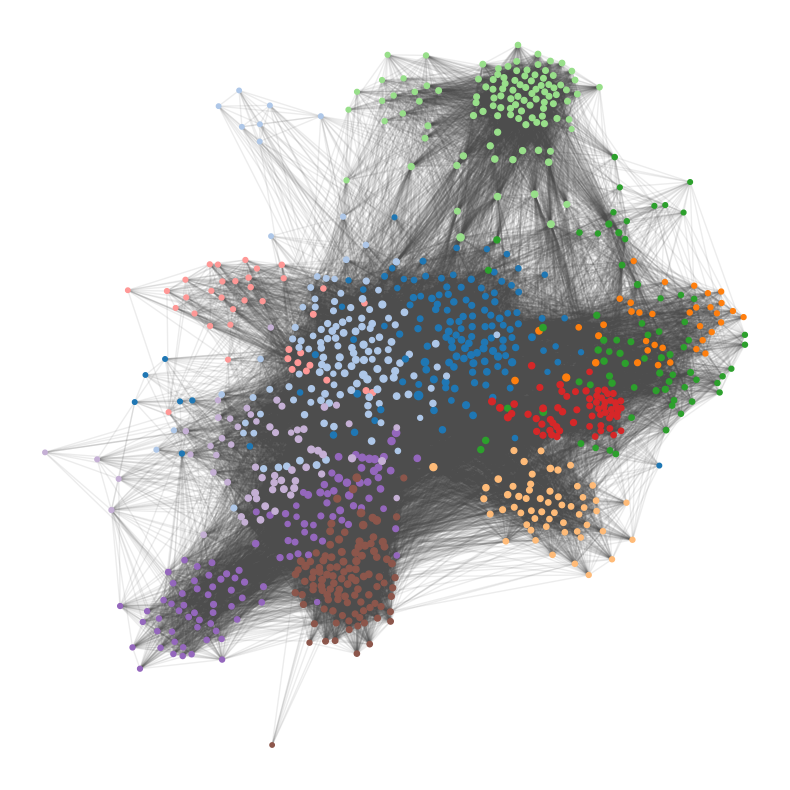

In [9]:
jobNetwork = buildGraph(jobJob, jobTitles)

## plots the network of jobs (not colored by exposure)
wrapNetPlot(jobNetwork, f"{curdir}/gpt_jobNetwork.pdf")

In [10]:
## outputs the clusters
Fout = open(f"{curdir}/jobNetworkCommunities.csv", "w")
Fout.write("Community\tColor\tJob Title\n")
for i in range(np.max(jobNetwork.vs["louvain community"]) + 1):
    print((i, tab20_colorNames[i]))
    V = [v["title"] for v in jobNetwork.vs if v["louvain community"] == i]
    print(V)
    print("--------")
    for v in V:
        Fout.write("%d\t%s\t%s\n" % (i, tab20_colorNames[i], v))
Fout.close()

(0, 'dark blue')
['Chief Executives', 'Chief Sustainability Officers', 'General and Operations Managers', 'Legislators', 'Advertising and Promotions Managers', 'Marketing Managers', 'Sales Managers', 'Public Relations Managers', 'Fundraising Managers', 'Administrative Services Managers', 'Facilities Managers', 'Security Managers', 'Computer and Information Systems Managers', 'Financial Managers', 'Treasurers and Controllers', 'Investment Fund Managers', 'Industrial Production Managers', 'Quality Control Systems Managers', 'Geothermal Production Managers', 'Biofuels Production Managers', 'Biomass Power Plant Managers', 'Hydroelectric Production Managers', 'Purchasing Managers', 'Transportation, Storage, and Distribution Managers', 'Supply Chain Managers', 'Compensation and Benefits Managers', 'Human Resources Managers', 'Training and Development Managers', 'Farmers, Ranchers, and Other Agricultural Managers', 'Construction Managers', 'Education and Childcare Administrators, Preschool an

In [11]:
jobType = []
for v in jobNetwork.vs:
    jobType.append({"Title": v["title"], "Type": v["louvain community"]})
jobType = pd.DataFrame(jobType)

temp = pd.merge(getTemp(), jobType)
T = (
    temp.groupby("Type")
    .agg(
        {
            f"{rating_desired}": [
                np.mean,
                np.median,
                np.std,
                lambda x: np.std(x) / np.sqrt(len(x)),
            ]
        }
    )
    .reset_index()
)
T.columns = T.columns.map("".join)
T = T.sort_values(by=f"{rating_desired}mean")

# map for cluster names
occtypes = {
    0: "Managers",
    1: "Clerks and Services",
    2: "Technologists",
    3: "Architects and Engineers",
    4: "Scientists and Researchers",
    5: "Medical Workers",
    6: "Legal Services",
    7: "Teachers",
    8: "Arts, Media, and Entertainment",
    9: "Operators",
    10: "Machinists",
}

# save clusters
temp["jobGroup"] = temp["Type"].map(occtypes)
T["jobArchetypeName"] = T.Type.map(occtypes)
temp.to_csv(f"{curdir}data/jobNetworkMembershipWithTypes.csv", index=False)

,Type,mean_rating_human_alphamean,mean_rating_human_alphamedian,mean_rating_human_alphastd,mean_rating_human_alpha<lambda_0>,jobArchetypeName
10,10,0.010048,0.0,0.098656,0.002062,Machinists
8,8,0.030472,0.0,0.170717,0.003677,"Arts, Media, and Entertainment"
9,9,0.034919,0.0,0.177353,0.005640,Operators
5,5,0.115403,0.0,0.315813,0.006960,Medical Workers
7,7,0.195504,0.0,0.390142,0.017142,Teachers
0,0,0.197613,0.0,0.387505,0.007453,Managers
3,3,0.204050,0.0,0.397363,0.011764,Architects and Engineers
1,1,0.213730,0.0,0.402452,0.008232,Clerks and Services
6,6,0.218100,0.0,0.399592,0.009694,Legal Services
2,2,0.261770,0.0,0.426881,0.015661,Technologists


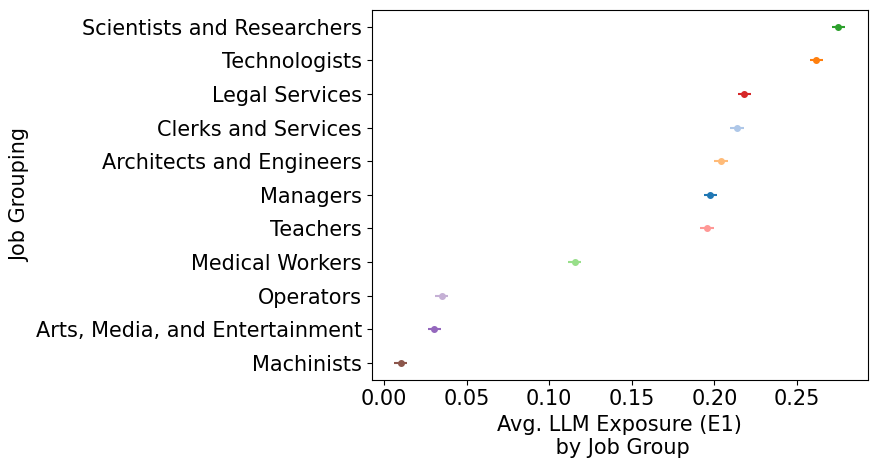

In [12]:
## cluster plot with means
plt.figure()
for i in range(T["jobArchetypeName"].count()):
    plt.errorbar(
        T[f"{rating_desired}mean"].iloc[i],
        i,
        xerr=1.96 * T[f"{rating_desired}<lambda_0>"].iloc[0],
        fmt="o",
        markersize=4,
        color=plt.cm.tab20.colors[T["Type"].iloc[i]],
    )

# x =
plt.yticks(np.arange(T["Type"].count()), T["jobArchetypeName"], fontsize=15)
plt.ylabel("Job Grouping", fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Avg. LLM Exposure (E1)\n by Job Group", fontsize=15)
plt.savefig(f"{curdir}/data/vecfigs/gptByJobType.pdf", bbox_inches="tight")
T

In [13]:
T.to_latex()

/var/folders/k_/b_m5t0mx4vl24jlst8tzbzxh0000gn/T/ipykernel_31508/1964746733.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  T.to_latex()


'\\begin{tabular}{lrrrrrl}\n\\toprule\n{} &  Type &  mean\\_rating\\_human\\_alphamean &  mean\\_rating\\_human\\_alphamedian &  mean\\_rating\\_human\\_alphastd &  mean\\_rating\\_human\\_alpha<lambda\\_0> &                jobArchetypeName \\\\\n\\midrule\n10 &    10 &                     0.010048 &                            0.0 &                    0.098656 &                           0.002062 &                      Machinists \\\\\n8  &     8 &                     0.030472 &                            0.0 &                    0.170717 &                           0.003677 &  Arts, Media, and Entertainment \\\\\n9  &     9 &                     0.034919 &                            0.0 &                    0.177353 &                           0.005640 &                       Operators \\\\\n5  &     5 &                     0.115403 &                            0.0 &                    0.315813 &                           0.006960 &                 Medical Workers \\\\\n7  &     7 &  

In [21]:
jobNetwork.vs.attributes()

['title',
 'name',
 'louvain community',
 'x',
 'y',
 'type mean_rating_human_alpha',
 'mean_rating_human_alpha']

/var/folders/k_/b_m5t0mx4vl24jlst8tzbzxh0000gn/T/ipykernel_31508/1691869888.py:6: DeprecationWarning: You are using integers as vertex names. This is discouraged because most igraph functions interpret integers as vertex _IDs_ and strings as vertex names. For sake of consistency, convert your vertex names to strings before assigning them. Future versions from igraph 0.11.0 will disallow integers as vertex names.
  G.add_vertex(i,title=nodeLabels[i])
/var/folders/k_/b_m5t0mx4vl24jlst8tzbzxh0000gn/T/ipykernel_31508/1691869888.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(layout[:,0],layout[:,1],s=nodeSize,c=nodeColors,


network modularity: 0.769, # node communities: 18


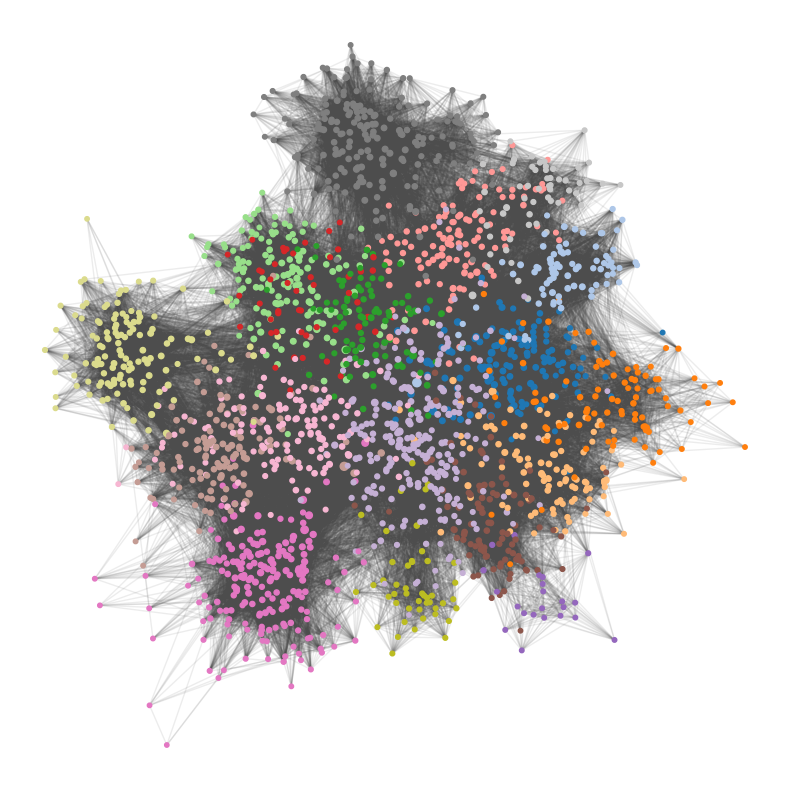

In [19]:
### now to look at detailed work activities (DWAs)
## build network
dwaNetwork = buildGraph(dwaDwa, DWAs)
wrapNetPlot(dwaNetwork, f"{curdir}/dwaNetwork.pdf")

In [20]:
dwaType = []
for v in dwaNetwork.vs:
    dwaType.append({"DWA Title": v["title"], "DWA Type": v["louvain community"]})
dwaType = pd.DataFrame(dwaType)
temp = pd.merge(temp, dwaType)
T = temp.groupby("Type").agg({f"{rating_desired}": np.mean}).reset_index()
TT = temp.groupby("Title").agg({f"{rating_desired}": np.mean}).reset_index()
for v in jobNetwork.vs:
    x = T[T["Type"] == v["louvain community"]]
    v[f"type {rating_desired}"] = x.iloc[0][f"{rating_desired}"]
    x = TT[TT["Title"] == v["title"]]
    v[f"{rating_desired}"] = x.iloc[0][f"{rating_desired}"]

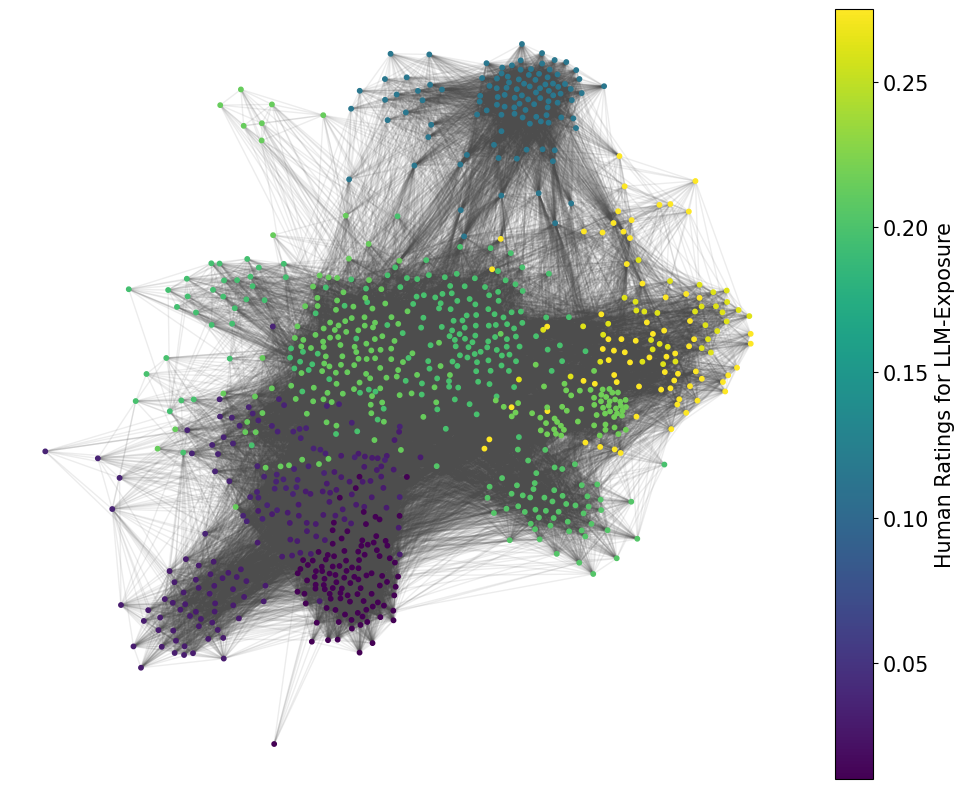

In [22]:
## network plot colored by exposure
plt.figure(figsize=(10, 8))
layout = np.vstack((jobNetwork.vs["x"], jobNetwork.vs["y"])).T
plotNetwork(
    jobNetwork,
    layout,
    nodeColors=jobNetwork.vs[f"type {rating_desired}"],
    nodeSize=10,
    lineColor=[0.3, 0.3, 0.3, 0.1],
    linewidth=1,
    cmap=plt.cm.viridis,
)
C = plt.colorbar()
C.ax.tick_params(labelsize=15)
# C.set_label(f"Job Type {rating_desired}",fontsize=15)
C.set_label(f"Human Ratings for LLM-Exposure", fontsize=15)
plt.tight_layout()
plt.savefig(f"{curdir}/gpt_jobnetwork.pdf")

In [23]:
## write clusters to file
Fout = open(f"{curdir}/dwaNetworkCommunities.csv", "w")
Fout.write("Community\tColor\tDWA Title\n")
for i in range(np.max(dwaNetwork.vs["louvain community"]) + 1):
    print((i, tab20_colorNames[i]))
    V = [v["title"] for v in dwaNetwork.vs if v["louvain community"] == i]
    print(V)
    print("--------")
    for v in V:
        Fout.write("%d\t%s\t%s\n" % (i, tab20_colorNames[i], v))
Fout.close()

(0, 'dark blue')
['Advise others on legal or regulatory compliance matters.', 'Analyze data to assess operational or project effectiveness.', 'Analyze data to inform operational decisions or activities.', 'Analyze impact of legal or regulatory changes.', 'Communicate organizational policies and procedures.', 'Confer with organizational members to accomplish work activities.', 'Coordinate special events or programs.', 'Coordinate with external parties to exchange information.', 'Develop organizational policies or programs.', 'Direct administrative or support services.', 'Direct financial operations.', 'Direct organizational operations, projects, or services.', 'Direct sales, marketing, or customer service activities.', 'Draft legislation or regulations.', 'Implement organizational process or policy changes.', 'Liaise between departments or other groups to improve function or communication.', 'Manage construction activities.', 'Manage human resources activities.', 'Negotiate contracts fo